In [1]:
!pip install pygame
!pip install numpy
!pip install Typing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for Typing: filename=typing-3.7.4.3-py3-none-any.whl size=26304 sha256=6c8bcd72d00fe6100757d61adb4e73688b0173fd28add80ccc32cb091b8f52c0
  Stored in directory: /root/.cache/pip/wheels/12/98/52/2bffe242a9a487f00886e43b8ed8dac46456702e11a0d6abef
Successfully built Typing


In [2]:
import pygame
import numpy as np
import random
import sys
from typing import Tuple

GRID_WIDTH, GRID_HEIGHT = 10, 20
CELL_SIZE = 30
SCREEN_WIDTH = GRID_WIDTH * CELL_SIZE
SCREEN_HEIGHT = GRID_HEIGHT * CELL_SIZE + 100

COLORS = {
    0: (0, 0, 0),
    1: (0, 240, 240),
    2: (240, 240, 0),
    3: (160, 0, 240),
    4: (240, 0, 0),
    5: (0, 240, 0),
    'grid': (40, 40, 40)
}

SHAPES = [
    (np.array([[1, 1, 1, 1]]), 1),
    (np.array([[2, 2], [2, 2]]), 2),
    (np.array([[0, 3, 0], [3, 3, 3]]), 3),
    (np.array([[4, 4, 0], [0, 4, 4]]), 4),
    (np.array([[0, 5, 5], [5, 5, 0]]), 5),
]

class Tetromino:
    def __init__(self, shape: np.ndarray, color_index: int):
        self.shape = shape
        self.color_index = color_index
        self.x = GRID_WIDTH // 2 - shape.shape[1] // 2
        self.y = 0

    def rotate(self) -> np.ndarray:
        return np.rot90(self.shape)

class TetrisGame:
    def __init__(self):
        pygame.init()
        self.screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
        pygame.display.set_caption("Tetris")
        self.clock = pygame.time.Clock()
        self.font = pygame.font.Font(None, 36)
        self.fall_time = 0
        self.fall_speed = 1000
        self.score = 0
        self.level = 1
        self.lines_cleared = 0
        self.line_scores = {1: 100, 2: 300, 3: 500, 4: 800}
        self.reset()

    def _new_piece(self) -> 'Tetromino':
        shape, color = random.choice(SHAPES)
        return Tetromino(shape, color)

    def _check_collision(self, shape: np.ndarray, x: int, y: int) -> bool:
        for row in range(shape.shape[0]):
            for col in range(shape.shape[1]):
                if shape[row][col] != 0:
                    grid_x = x + col
                    grid_y = y + row
                    if (grid_x < 0 or grid_x >= GRID_WIDTH or
                        grid_y >= GRID_HEIGHT or
                        (grid_y >= 0 and self.grid[grid_y][grid_x] != 0)):
                        return True
        return False

    def _merge_piece(self):
        for row in range(self.current_piece.shape.shape[0]):
            for col in range(self.current_piece.shape.shape[1]):
                if self.current_piece.shape[row][col] != 0:
                    x = self.current_piece.x + col
                    y = self.current_piece.y + row
                    if 0 <= y < GRID_HEIGHT:
                        self.grid[y][x] = self.current_piece.color_index

    def _clear_lines(self):
        complete_lines = 0
        new_grid = []
        for row in self.grid:
            if not np.all(row != 0):
                new_grid.append(row)
            else:
                complete_lines += 1
        while len(new_grid) < GRID_HEIGHT:
            new_grid.insert(0, np.zeros(GRID_WIDTH, dtype=int))
        self.grid = np.array(new_grid)

        if complete_lines > 0:
            self.lines_cleared += complete_lines
            self.score += self.line_scores.get(complete_lines, 0)
            self.level = self.lines_cleared // 10 + 1

        return complete_lines

    def step(self, action: int) -> Tuple[np.ndarray, int, bool]:
        moved = False
        if action == 0 and not self._check_collision(self.current_piece.shape, self.current_piece.x - 1, self.current_piece.y):
            self.current_piece.x -= 1
            moved = True
        elif action == 1 and not self._check_collision(self.current_piece.shape, self.current_piece.x + 1, self.current_piece.y):
            self.current_piece.x += 1
            moved = True
        elif action == 2:
            rotated_shape = self.current_piece.rotate()
            if not self._check_collision(rotated_shape, self.current_piece.x, self.current_piece.y):
                self.current_piece.shape = rotated_shape
                moved = True
        elif action == 3:
            while not self._check_collision(self.current_piece.shape, self.current_piece.x, self.current_piece.y + 1):
                self.current_piece.y += 1
            self._merge_piece()
            lines_cleared = self._clear_lines()
            reward = lines_cleared * 100 + (self.current_piece.y * 2)
            self.current_piece = self._new_piece()
            if self._check_collision(self.current_piece.shape, self.current_piece.x, self.current_piece.y):
                self.game_over = True
            return self.get_state(), reward, self.game_over
        return self.get_state(), 1 if moved else -1, self.game_over

    def reset(self) -> np.ndarray:
        self.grid = np.zeros((GRID_HEIGHT, GRID_WIDTH), dtype=int)
        self.current_piece = self._new_piece()
        self.game_over = False
        self.score = 0
        self.lines_cleared = 0
        self.level = 1
        return self.get_state()

    def get_state(self) -> np.ndarray:
        state = self.grid.copy()
        for row in range(self.current_piece.shape.shape[0]):
            for col in range(self.current_piece.shape.shape[1]):
                if self.current_piece.shape[row][col] != 0:
                    x = self.current_piece.x + col
                    y = self.current_piece.y + row
                    if 0 <= y < GRID_HEIGHT:
                        state[y][x] = self.current_piece.color_index
        return state

    def update(self, dt: int):
        self.fall_time += dt
        if self.fall_time > self.fall_speed / self.level:
            self.fall_time = 0
            if not self._check_collision(self.current_piece.shape, self.current_piece.x, self.current_piece.y + 1):
                self.current_piece.y += 1
            else:
                self._merge_piece()
                lines_cleared = self._clear_lines()
                self.current_piece = self._new_piece()
                if self._check_collision(self.current_piece.shape, self.current_piece.x, self.current_piece.y):
                    self.game_over = True

    def render(self):
        self.screen.fill((0, 0, 0))

        # Draw grid background
        for x in range(GRID_WIDTH):
            for y in range(GRID_HEIGHT):
                rect = pygame.Rect(x * CELL_SIZE, y * CELL_SIZE, CELL_SIZE, CELL_SIZE)
                pygame.draw.rect(self.screen, COLORS['grid'], rect, 1)

        # Draw placed pieces
        for y in range(GRID_HEIGHT):
            for x in range(GRID_WIDTH):
                if self.grid[y][x] != 0:
                    rect = pygame.Rect(x * CELL_SIZE, y * CELL_SIZE, CELL_SIZE, CELL_SIZE)
                    pygame.draw.rect(self.screen, COLORS[self.grid[y][x]], rect)

        # Draw current piece
        for row in range(self.current_piece.shape.shape[0]):
            for col in range(self.current_piece.shape.shape[1]):
                if self.current_piece.shape[row][col] != 0:
                    x = (self.current_piece.x + col) * CELL_SIZE
                    y = (self.current_piece.y + row) * CELL_SIZE
                    rect = pygame.Rect(x, y, CELL_SIZE, CELL_SIZE)
                    pygame.draw.rect(self.screen, COLORS[self.current_piece.color_index], rect)

        # Render score and level
        score_text = self.font.render(f'Score: {self.score}', True, (255, 255, 255))
        level_text = self.font.render(f'Level: {self.level}', True, (255, 255, 255))

        # Render texts below the grid
        self.screen.blit(score_text, (10, SCREEN_HEIGHT - 80))
        self.screen.blit(level_text, (10, SCREEN_HEIGHT - 40))

        pygame.display.flip()

def main():
    game = TetrisGame()
    running = True
    while running:
        dt = game.clock.tick(60)
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_LEFT:
                    game.step(0)
                elif event.key == pygame.K_RIGHT:
                    game.step(1)
                elif event.key == pygame.K_UP:
                    game.step(2)
                elif event.key == pygame.K_DOWN:
                    game.step(3)

        game.update(dt)
        game.render()

        if game.game_over:
            game_over_text = game.font.render('GAME OVER', True, (255, 0, 0))
            game.screen.blit(game_over_text, (SCREEN_WIDTH // 2 - game_over_text.get_width() // 2, SCREEN_HEIGHT // 2))
            pygame.display.flip()
            pygame.time.wait(2000)
            running = False

    pygame.quit()
    sys.exit()

pygame 2.6.1 (SDL 2.28.4, Python 3.12.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import pygame
from collections import deque

rewards=[]
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(list(self.buffer), batch_size)

    def __len__(self):
        return len(self.buffer)

class TetrisCNN(nn.Module):
    def __init__(self):
        super(TetrisCNN, self).__init__()
        # Fully connected layers for grid-based state
        input_size = GRID_WIDTH * GRID_HEIGHT
        hidden_size = 256

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 4)  # 4 actions: left, right, rotate, drop

    def forward(self, x):
        # Flatten the input state
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class TetrisAI:
    def __init__(self, game):
        self.game = game
        self.model = TetrisCNN()
        self.target_model = TetrisCNN()
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.replay_buffer = ReplayBuffer(10000)

        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        self.gamma = 0.99
        self.batch_size = 32
        self.target_update = 10
        self.steps = 0

    def get_state_tensor(self, state):
        # Convert numpy array to torch tensor
        return torch.FloatTensor(state).unsqueeze(0)

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 3)

        with torch.no_grad():
            state_tensor = self.get_state_tensor(state)
            q_values = self.model(state_tensor)
            return q_values.argmax().item()

    def train_step(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        transitions = self.replay_buffer.sample(self.batch_size)
        batch = list(zip(*transitions))

        state_batch = torch.FloatTensor(batch[0])
        action_batch = torch.LongTensor(batch[1]).unsqueeze(1)
        reward_batch = torch.FloatTensor(batch[2]).unsqueeze(1)
        next_state_batch = torch.FloatTensor(batch[3])
        done_batch = torch.FloatTensor(batch[4]).unsqueeze(1)

        current_q_values = self.model(state_batch).gather(1, action_batch)
        next_q_values = self.target_model(next_state_batch).max(1)[0].detach().unsqueeze(1)
        target_q_values = reward_batch + (1 - done_batch) * self.gamma * next_q_values

        loss = F.smooth_l1_loss(current_q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.steps += 1
        if self.steps % self.target_update == 0:
            self.target_model.load_state_dict(self.model.state_dict())

    def train(self, num_episodes):
        for episode in range(num_episodes):
            state = self.game.reset()
            total_reward = 0
            done = False

            while not done:
                action = self.select_action(state)
                next_state, reward, done = self.game.step(action)

                self.replay_buffer.push(state, action, reward, next_state, done)
                self.train_step()

                state = next_state
                total_reward += reward

                rewards.append(total_reward)

            # Decay epsilon
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            if episode % 10 == 0:
                print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {self.epsilon:.3f}")

def main():
    game = TetrisGame()
    ai = TetrisAI(game)
    ai.train(num_episodes=1000)

if __name__ == "__main__":
    main()

Episode 0, Total Reward: 199, Epsilon: 0.999
Episode 10, Total Reward: 256, Epsilon: 0.989
Episode 20, Total Reward: 253, Epsilon: 0.979
Episode 30, Total Reward: 274, Epsilon: 0.969
Episode 40, Total Reward: 356, Epsilon: 0.960
Episode 50, Total Reward: 309, Epsilon: 0.950
Episode 60, Total Reward: 263, Epsilon: 0.941
Episode 70, Total Reward: 265, Epsilon: 0.931
Episode 80, Total Reward: 196, Epsilon: 0.922
Episode 90, Total Reward: 496, Epsilon: 0.913
Episode 100, Total Reward: 331, Epsilon: 0.904
Episode 110, Total Reward: 307, Epsilon: 0.895
Episode 120, Total Reward: 339, Epsilon: 0.886
Episode 130, Total Reward: 317, Epsilon: 0.877
Episode 140, Total Reward: 335, Epsilon: 0.868
Episode 150, Total Reward: 272, Epsilon: 0.860
Episode 160, Total Reward: 312, Epsilon: 0.851
Episode 170, Total Reward: 273, Epsilon: 0.843
Episode 180, Total Reward: 366, Epsilon: 0.834
Episode 190, Total Reward: 278, Epsilon: 0.826
Episode 200, Total Reward: 239, Epsilon: 0.818
Episode 210, Total Rewar

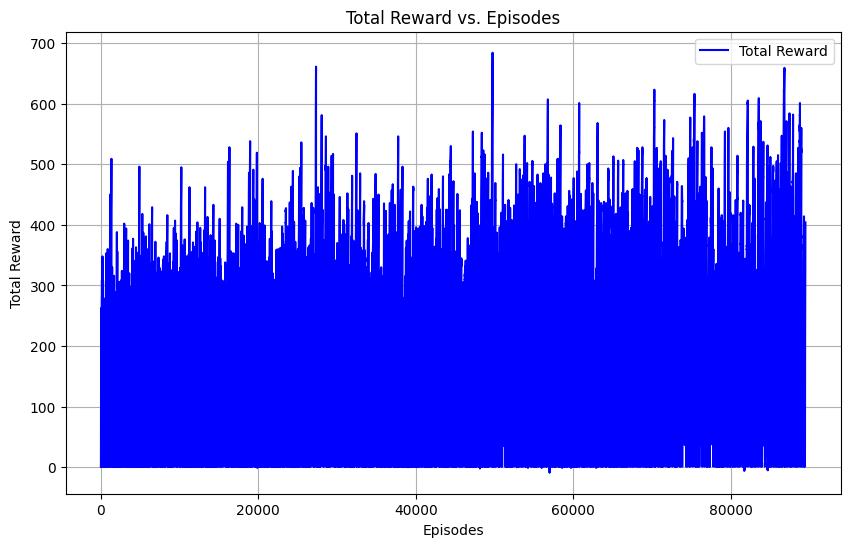

In [9]:
import matplotlib.pyplot as plt

def plot_rewards_per_episode(rewards):
    episodes = range(1, len(rewards) + 1)  # Episode numbers (1, 2, 3, ...)

    plt.figure(figsize=(10, 6))
    plt.plot(episodes, rewards, label='Total Reward', color='blue')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('Total Reward vs. Episodes')
    plt.grid()
    plt.legend()
    plt.show()

plot_rewards_per_episode(rewards)


In [8]:
print(rewards)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 45, 46, 76, 77, 78, 79, 80, 106, 107, 108, 109, 131, 132, 152, 153, 167, 168, 180, 181, 182, 183, 184, 185, 186, 187, 188, 196, 197, 198, 199, 199, 36, 37, 38, 39, 73, 103, 104, 105, 106, 107, 108, 134, 158, 178, 179, 180, 216, 232, 233, 234, 244, 252, 253, 254, 255, 261, 263, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 47, 48, 49, 79, 80, 81, 82, 83, 84, 118, 144, 166, 167, 168, 169, 189, 190, 191, 192, 191, 209, 210, 211, 212, 213, 214, 215, 231, 243, 253, 254, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 277, 278, 279, 280, 281, 281, 280, 282, 283, 282, 281, 282, 283, 282, 283, 309, 1, 2, 3, 39, 71, 99, 100, 101, 102, 103, 104, 103, 102, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 166, 188, 189, 190, 191, 192, 212, 213, 214, 215, 216, 230, 231, 232, 233, 234, 235, 234, 235, 236, 237, 238, 270, 288, 289, 305, 306, 307, 308, 309, 310, 311, 312, 324, 325, 335, 336, 344, 345, 346, 348, 1, 2, 3, 4, 5, 41, 42, 76, 108, 109, 110, 134, 13

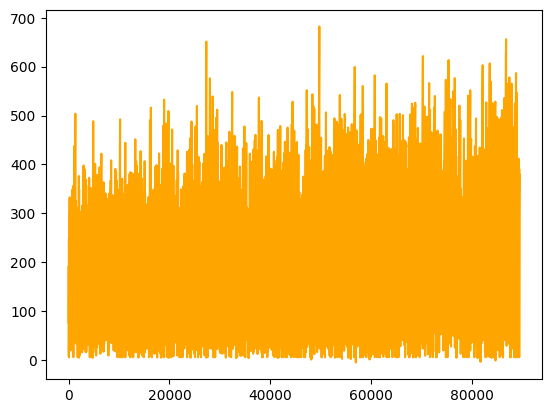

In [10]:
def smooth_rewards(rewards, window_size=10):
    cumsum = np.cumsum(np.insert(rewards, 0, 0))
    return (cumsum[window_size:] - cumsum[:-window_size]) / window_size

smoothed_rewards = smooth_rewards(rewards, window_size=10)
plt.plot(range(1, len(smoothed_rewards) + 1), smoothed_rewards, label='Smoothed Reward', color='orange')
